# chapter 9. 一歩進んだ文法

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 9.2 ベクトル化による高速化
### 9.2.1 ベクトル化の基本

In [2]:
model_9_1b = """
data {
  int N;
  vector[N] X;
  vector[N] Y;
  int N_new;
  vector[N_new] X_new;
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  mu = a + b*X;
}

model {
  Y ~ normal(mu, sigma);
}

generated quantities {
  vector[N_new] Y_new;
  for (n in 1:N_new)
    Y_new[n] = normal_rng(a + b*X_new[n], sigma);
}
"""

In [3]:
df_1 = pd.read_csv('../chap04/input/data-salary.txt')
data_1 = df_1.to_dict('list')
data_1['N'] = len(df_1)
data_1['X_new'] = np.linspace(20, 65, 45)
data_1['N_new'] = len(data_1['X_new'])

In [4]:
fit_1 = pystan.stan(model_code=model_9_1b, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6d4bec653484d3073e815f93f98675c NOW.


In [5]:
def plot_pred_range(fit, xs, ys_key, percentiles, alpha):
    ys = (fit.extract(permuted=True))[ys_key].T
    plt.fill_between( \
        xs, \
        [np.percentile(y, percentiles[0]) for y in ys], \
        [np.percentile(y, percentiles[1]) for y in ys], alpha=alpha)

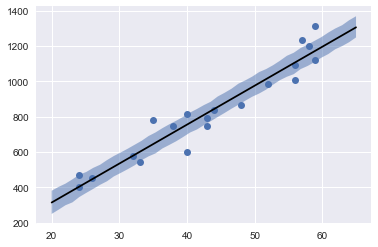

In [6]:
a = np.percentile( fit_1.extract(permuted=True)['a'].T, 50)
b = np.percentile( fit_1.extract(permuted=True)['b'].T, 50)
plt.plot(df_1['X'], df_1['Y'], "o")
plot_pred_range(fit_1, data_1['X_new'], 'Y_new', (25, 75), 0.5)
plt.plot(data_1['X_new'], a+b*data_1['X_new'], 'k-')
plt.show()

### 9.2.2 ベクトル化の応用例--その(1)

see 練習問題(4)

### 9.2.3 ベクトル化の応用例--その(2)

In [7]:
model_8_7b = """
data {
  int N;
  int T;
  vector[T] Time;
  matrix[N,T] Y;
  int T_new;
  vector[T_new] Time_new;
}

parameters {
  real a0;
  real b0;
  vector[N] log_a;
  vector[N] log_b;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[N] a;
  vector[N] b;
  matrix[N,T] mu;
  a = exp(log_a);
  b = exp(log_b);
  for (t in 1:T)
    for (n in 1:N)
      mu[n,t] = a[n]*(1 - exp(-b[n]*Time[t]));
}

model {
  log_a ~ normal(a0, s_a);
  log_b ~ normal(b0, s_b);
  to_vector(Y) ~ normal(to_vector(mu), s_Y);
}

generated quantities {
  real y_new[N,T_new];
  for (n in 1:N)
    for (t in 1:T_new)
      y_new[n,t] = normal_rng(a[n]*(1 - exp(-b[n]*Time_new[t])), s_Y);
}
"""

In [8]:
df_8_7 = pd.read_csv('../chap08/input/data-conc-2.txt')
times = [1,2,4,8,12,24]
cols = ['Time'+str(time) for time in times]
ts = np.linspace(0, 24, 60)
data_8_7 = {'N':len(df_8_7), 'T':len(times), 'Time':times, 'T_new':len(ts), 'Time_new':ts}
data_8_7['Y'] = np.asarray([list(df_8_7[col]) for col in cols]).T.tolist()

In [9]:
fit_8_7 = pystan.stan(model_code=model_8_7b, data=data_8_7, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f226fa7fd9c142855ac118e8a90c40e NOW.


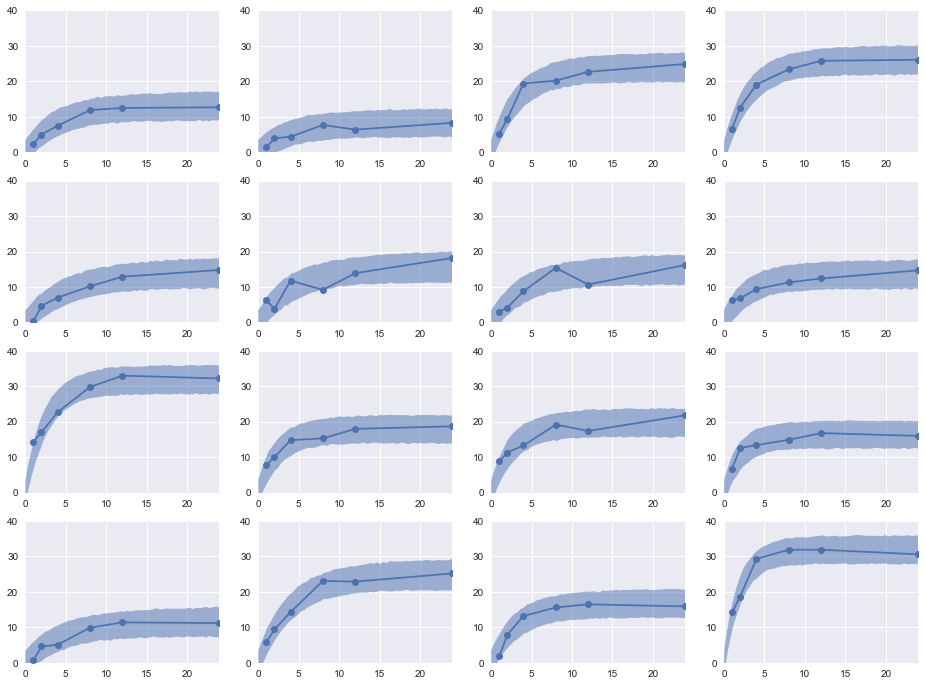

In [10]:
yt = fit_8_7.extract(permuted=True)['y_new'].transpose(1,2,0)
f, axarr = plt.subplots(4, 4, figsize=(16, 12))
for i in range(0, 16):
    yti = yt[i]
    yli = [np.percentile(y, 2.5) for y in yti]
    yhi = [np.percentile(y, 97.5) for y in yti]
    axarr[i//4, i%4].plot(times, data_8_7['Y'][i], 'o-')
    axarr[i//4, i%4].fill_between(data_8_7['Time_new'], yli, yhi, alpha=0.5)
    axarr[i//4, i%4].set_xlim((0, 24))
    axarr[i//4, i%4].set_ylim((0, 40))
plt.show()

## 9.3 ベクトルや行列の数学的性質の利用
### 9.3.1 多変量正規分布

In [11]:
df_9_2 = pd.read_csv('input/data-mvn.txt')
print(df_9_2.shape)
df_9_2.head()

(32, 2)


,Y1,Y2
0,9.2,2.56
1,9.8,1.99
2,9.4,2.40
3,9.2,2.27
4,8.1,3.68


In [12]:
data_9_2 = dict()
data_9_2['N'] = len(df_9_2)
data_9_2['D'] = 2
data_9_2['Y'] = []
for y1,y2 in zip(df_9_2['Y1'],df_9_2['Y2']):
    data_9_2['Y'].append([y1,y2])
#data_9_2    

In [13]:
model_9_2 = """
data {
  int N;
  int D;
  vector[D] Y[N];
}

parameters {
  vector[D] mn;
  cov_matrix[D] cov;
}

model {
  for (n in 1:N)
    Y[n] ~ multi_normal(mn, cov);
}
"""

In [14]:
%time fit_9_2 = pystan.stan(model_code=model_9_2, data=data_9_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_049d7a30bc97ec009cde0548f03429a0 NOW.


CPU times: user 1.05 s, sys: 87.4 ms, total: 1.13 s
Wall time: 28.3 s


In [15]:
print(fit_9_2)

Inference for Stan model: anon_model_049d7a30bc97ec009cde0548f03429a0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mn[0]      9.19  3.8e-3   0.11   8.97   9.12    9.2   9.27   9.41    878    1.0
mn[1]      2.56  2.8e-3   0.09   2.39    2.5   2.56   2.62   2.75   1128    1.0
cov[0,0]   0.42  3.4e-3   0.12   0.24   0.33    0.4   0.49   0.72   1380    1.0
cov[1,0]   -0.3  2.6e-3   0.09  -0.53  -0.35  -0.29  -0.23  -0.16   1262    1.0
cov[0,1]   -0.3  2.6e-3   0.09  -0.53  -0.35  -0.29  -0.23  -0.16   1262    1.0
cov[1,1]   0.29  2.3e-3   0.08   0.17   0.23   0.27   0.33    0.5   1327    1.0
lp__      25.14    0.06   1.72  20.94  24.29  25.45   26.4  27.42    864    1.0

Samples were drawn using NUTS at Wed Apr 26 20:13:30 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction 

In [16]:
model_9_2a = """
data {
  int N;
  int D;
  vector[D] Y[N];
}

parameters {
  vector[D] mn;
  cov_matrix[D] cov;
}

model {
  Y ~ multi_normal(mn, cov);
}
"""

In [17]:
%time fit_9_2a = pystan.stan(model_code=model_9_2a, data=data_9_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b2da58afbd4e86c1fa7764fb5993b9f NOW.


CPU times: user 1.32 s, sys: 112 ms, total: 1.43 s
Wall time: 26.2 s


### 9.3.2 行列演算を使った重回帰

In [18]:
df_9_3 = pd.read_csv('input/data-attendance-5.txt')
df_9_3['dummy'] = 1
print(df_9_3.shape)
df_9_3.head()


(50, 6)


,A,Score,X3,X4,Y,dummy
0,0,69,-0.56,1.20,0.286,1
1,1,145,-0.23,0.67,0.196,1
2,0,125,1.56,0.98,0.261,1
3,1,86,0.07,1.91,0.109,1
4,1,158,0.13,0.97,0.230,1


In [19]:
data_9_3 = dict()
data_9_3['X'] = list(df_9_3[['dummy','A','Score','X3','X4']].T.to_dict('list').values())
data_9_3['Y'] = list(df_9_3['Y'])
data_9_3['N'] = len(data_9_3['X'])
data_9_3['D'] = 5

In [20]:
model_9_3 = """
data {
  int N;
  int D;
  matrix[N,D] X;
  vector<lower=0, upper=1>[N] Y;
}

parameters {
  vector[D] b;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  mu = X*b;
}

model {
  Y ~ normal(mu, sigma);
}
"""

In [21]:
%time fit_9_3 = pystan.stan(model_code=model_9_3, data=data_9_3, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_565b73b2f402277075fea40e7aec75ab NOW.


CPU times: user 1.11 s, sys: 80.5 ms, total: 1.19 s
Wall time: 24.6 s


In [22]:
print(fit_9_3)

Inference for Stan model: anon_model_565b73b2f402277075fea40e7aec75ab.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]     0.14  1.2e-3   0.04   0.06   0.11   0.14   0.16   0.21   1043    1.0
b[1]    -0.14  4.6e-4   0.02  -0.17  -0.15  -0.14  -0.13  -0.11   1232    1.0
b[2]   1.6e-3  8.0e-6 2.8e-4 1.1e-3 1.4e-3 1.6e-3 1.8e-3 2.2e-3   1197    nan
b[3]  -2.9e-3  2.0e-4 8.3e-3  -0.02-8.5e-3-2.9e-3 2.6e-3   0.01   1665    1.0
b[4]    -0.01  3.8e-4   0.01  -0.04  -0.02  -0.01-4.3e-3   0.01   1169    1.0
sigma    0.05  1.7e-4 5.7e-3   0.04   0.05   0.05   0.06   0.06   1103    1.0
mu[0]    0.23  4.3e-4   0.02    0.2   0.22   0.23   0.25   0.27   1511    1.0
mu[1]    0.22  3.8e-4   0.01   0.19   0.21   0.22   0.23   0.25   1469    1.0
mu[2]    0.32  3.7e-4   0.02   0.29   0.31   0.32   0.33   0.35   1694    1.0
mu[3]    0.11  3.8e-4   0.02   0.

## 9.4 パラメータの制約

### 9.4.2 simplex型

In [23]:
model_9_5 = """
data {
  int K;
  int<lower=0> Y[K];
}

parameters {
  simplex[K] theta;
}

model {
  Y ~ multinomial(theta);
}
"""

ここでは集計は非常に手抜きで集計した

In [25]:
df_9_5 = pd.read_csv('input/data-dice.txt')
ds = df_9_5['Face'].values
acc = []
for d in range(1,7):
    acc.append(len([x for x in ds if x==d]))
df_9_5 = pd.read_csv('input/data-dice.txt')
data_9_5 = dict()
data_9_5['Y'] = acc
data_9_5['N'] = len(df_9_5)
data_9_5['K'] = 6
data_9_5

{'K': 6, 'N': 200, 'Y': [21, 75, 20, 51, 19, 14]}

In [26]:
%time fit_9_5 = pystan.stan(model_code=model_9_5, data=data_9_5, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e381bb7dd0efbf89a0228b73dfb25f85 NOW.


CPU times: user 1.26 s, sys: 86.3 ms, total: 1.34 s
Wall time: 21.9 s


In [27]:
print(fit_9_5)

Inference for Stan model: anon_model_e381bb7dd0efbf89a0228b73dfb25f85.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]   0.11  4.8e-4   0.02   0.07   0.09   0.11   0.12   0.15   2000    1.0
theta[1]   0.37  7.8e-4   0.03    0.3   0.34   0.37   0.39   0.44   2000    1.0
theta[2]    0.1  4.6e-4   0.02   0.07   0.09    0.1   0.11   0.14   2000    1.0
theta[3]   0.25  6.6e-4   0.03    0.2   0.23   0.25   0.27   0.31   2000    1.0
theta[4]    0.1  4.7e-4   0.02   0.06   0.08    0.1   0.11   0.14   2000    1.0
theta[5]   0.07  4.0e-4   0.02   0.04   0.06   0.07   0.08   0.11   2000    1.0
lp__     -333.0    0.06   1.61 -336.9 -333.7 -332.6 -331.8 -330.9    851    1.0

Samples were drawn using NUTS at Wed Apr 26 20:17:48 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction 

## 9.5 トラブルシューティング

### 9.5.2 欠測値

In [28]:
model_9_6 = """
data {
  int I;
  int N;
  int T;
  real Time[T];
  int<lower=1, upper=N> PersonID[I];
  int<lower=1, upper=T> TimeID[I];
  vector[I] Y;
}

parameters {
  real a0;
  real b0;
  vector[N] log_a;
  vector[N] log_b;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[N] a;
  vector[N] b;
  row_vector[T] mu[N];
  a = exp(log_a);
  b = exp(log_b);
  for (n in 1:N)
    for (t in 1:T)
      mu[n,t] = a[n]*(1 - exp(-b[n]*Time[t]));
}

model {
  log_a ~ normal(a0, s_a);
  log_b ~ normal(b0, s_b);
  for (i in 1:I)
    Y[i] ~ normal(mu[PersonID[i], TimeID[i]], s_Y);
}
"""

In [29]:
df_9_6 = pd.read_csv('input/data-conc-2-NA-long.txt')
data_9_6 = df_9_6.to_dict('list')
data_9_6['Time'] = [1,2,4,8,12,24]
data_9_6['T'] = len(data_9_6['Time'])
data_9_6['N'] = np.max(data_9_6['PersonID'])
data_9_6['I'] = len(df_9_6)

In [30]:
%time fit_9_6 = pystan.stan(model_code=model_9_6, data=data_9_6, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0fa6b886484470ba906a29f5325513a3 NOW.


CPU times: user 1.13 s, sys: 82.6 ms, total: 1.21 s
Wall time: 23.6 s


In [31]:
print(fit_9_6)

Inference for Stan model: anon_model_0fa6b886484470ba906a29f5325513a3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0          2.87  2.4e-3   0.11   2.66    2.8   2.88   2.95   3.09   2000    1.0
b0         -1.19  3.7e-3   0.14  -1.47  -1.28  -1.18   -1.1  -0.93   1448    1.0
log_a[0]     2.6  4.0e-3   0.15   2.33    2.5   2.59   2.69   2.95   1489    1.0
log_a[1]    2.11  3.2e-3   0.14   1.82   2.02   2.11   2.21    2.4   2000    1.0
log_a[2]    3.27  5.6e-3   0.21   2.92   3.13   3.26    3.4   3.72   1336    1.0
log_a[3]    3.25  1.1e-3   0.05   3.16   3.22   3.25   3.29   3.35   2000    1.0
log_a[4]    2.65  2.7e-3   0.12   2.43   2.57   2.65   2.73   2.89   1801    1.0
log_a[5]    2.75  2.5e-3    0.1   2.56   2.69   2.75   2.82   2.96   1663    1.0
log_a[6]     2.7  2.0e-3   0.09   2.52   2.63    2.7   2.76   2.87   2000    1.0
log

## 練習問題(1)

In [32]:
model_5_3 = """
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  real<lower=0, upper=1> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*A[n] + b3*Score[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(mu[n], sigma);
}
"""

In [33]:
model_9_ex1 = """
data {
  int N;
  vector<lower=0, upper=1>[N] A;
  vector<lower=0, upper=1>[N] Score;
  vector<lower=0, upper=1>[N] Y;
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  mu = b1 + b2*A + b3*Score;
}

model {
  Y ~ normal(mu, sigma);
}

generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(mu[n], sigma);
}
"""

In [34]:
df_ex1 = pd.read_csv('../chap05/input/data-attendance-1.txt')
data_ex1 = df_ex1.to_dict('list')
data_ex1['N'] = len(df_ex1)
data_ex1['Score'] = [x/200 for x in data_ex1['Score']]

In [35]:
fit_ex1 = pystan.stan(model_code=model_9_ex1, data=data_ex1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41a596b799826f388b5207ebfeb74dd0 NOW.


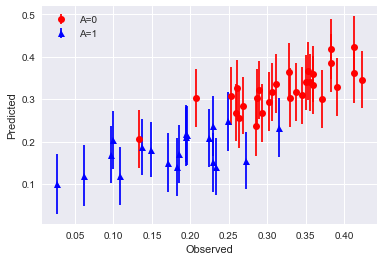

In [36]:
la_ex1 = fit_ex1.extract(permuted=True)
y_preds = la_ex1['y_pred'].T
df_ex1['y_10'] = [np.percentile(xs, 10.0) for xs in y_preds]
df_ex1['y_90'] = [np.percentile(xs, 90.0) for xs in y_preds]
df_ex1['mu'] = [np.average(xs) for xs in la_ex1['mu'].T]
df_ex1['errorbar'] = (df_ex1['y_90'] - df_ex1['y_10'])/2
for a in [0,1]:
  df = df_ex1[df_ex1['A']==a]
  plt.errorbar(df['Y'], df['mu'], yerr=df['errorbar'], fmt=["or", "^b"][a], label='A='+str(a))
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

## 練習問題(2)

In [37]:
model_5_6b = """
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = b[1] + b[2]*A[n] + b[3]*Score[n];
}

model {
  for (n in 1:N)
    M[n] ~ poisson_log(lambda[n]);
}

generated quantities {
  int m_pred[N];
  for (n in 1:N)
    m_pred[n] = poisson_log_rng(lambda[n]);
}
"""

In [38]:
model_9_ex2 = """
data {
  int N;
  vector<lower=0, upper=1>[N] A;
  vector<lower=0, upper=1>[N] Score;
  int<lower=0> M[N];
}

parameters {
  vector[3] b;
}

transformed parameters {
  vector<lower=0>[N] lambda;
  for (n in 1:N)
    lambda = b[1] + b[2]*A + b[3]*Score;
}

model {
  for (n in 1:N)
    M ~ poisson_log(lambda);
}

generated quantities {
  int m_pred[N];
  for (n in 1:N)
    m_pred[n] = poisson_log_rng(lambda[n]);
}
"""

In [39]:
df_ex2 = pd.read_csv('../chap05/input/data-attendance-2.txt')
data_ex2 = df_ex2.to_dict('list')
data_ex2['N'] = len(df_ex2)
data_ex2['Score'] = [x/200 for x in data_ex2['Score']]
color=['red', 'blue']

In [40]:
fit_ex2 = pystan.stan(model_code=model_9_ex2, data=data_ex2, iter=1000, chains=4)
print(fit_ex2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f058e9364d8c6d55028d374819807665 NOW.


Inference for Stan model: anon_model_f058e9364d8c6d55028d374819807665.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         3.58  5.3e-4   0.01   3.55   3.57   3.58   3.59    3.6    662    1.0
b[1]         0.26  1.8e-4 5.8e-3   0.25   0.26   0.26   0.27   0.28    999    1.0
b[2]         0.29  8.1e-4   0.02   0.25   0.28   0.29    0.3   0.33    666    1.0
lambda[0]    3.68  2.6e-4 7.0e-3   3.66   3.67   3.68   3.68   3.69    735    1.0
lambda[1]    4.05  1.5e-4 4.8e-3   4.04   4.05   4.05   4.06   4.06   1087    1.0
lambda[2]    3.76  1.0e-4 4.0e-3   3.75   3.76   3.76   3.76   3.77   1496    1.0
lambda[3]    3.97  1.8e-4 5.7e-3   3.96   3.96   3.97   3.97   3.98    946    1.0
lambda[4]    4.07  1.8e-4 5.6e-3   4.06   4.07   4.07   4.08   4.08    928    1.0
lambda[5]    3.77  1.1e-4 4.1e-3   3.76   3.77   3.77   3.77   3.78   1526 

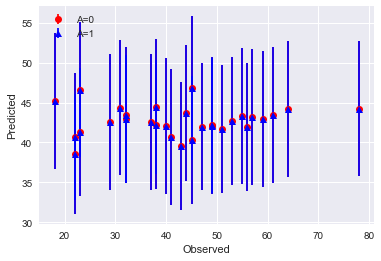

In [41]:
la_ex2 = fit_ex2.extract(permuted=True)
m_preds = la_ex2['m_pred'].T
df_ex2['m_10'] = [np.percentile(xs, 10.0) for xs in m_preds]
df_ex2['m_90'] = [np.percentile(xs, 90.0) for xs in m_preds]
df_ex2['lam'] = [np.exp(np.percentile(xs, 50.0)) for xs in la_ex2['lambda'].T]
df_ex2['errorbar'] = (df_ex2['m_90'] - df_ex2['m_10'])/2
for a in [0,1]:
  df = df_ex2[df_ex2['A']==0]
  plt.errorbar(df['M'], df['lam'], yerr=df['errorbar'], fmt=["or","^b"][a], label='A='+str(a))
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

## 練習問題(3)

`real dot_product(vector x, vector y)` 

## 練習問題(4)

In [42]:
model_8_5 = """
data {
  int N;
  int G;
  int K;
  real X[N];
  real Y[N];
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
}

parameters {
  real a0;
  real b0;
  real a1[G];
  real b1[G];
  real a[K];
  real b[K];
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

model {
  for (g in 1:G) {
    a1[g] ~ normal(a0, s_ag);
    b1[g] ~ normal(b0, s_bg);
  }

  for (k in 1:K) {
    a[k] ~ normal(a1[K2G[k]], s_a);
    b[k] ~ normal(b1[K2G[k]], s_b);
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]] + b[KID[n]]*X[n], s_Y);
}
"""

In [43]:
model_9_ex4 = """
data {
  int N;
  int G;
  int K;
  vector[N] X;
  vector[N] Y;
  int<lower=1, upper=K> KID[N];
  int<lower=1, upper=G> K2G[K];
}

parameters {
  real a0;
  real b0;
  vector[G] a1;
  vector[G] b1;
  vector[K] a;
  vector[K] b;
  real<lower=0> s_ag;
  real<lower=0> s_bg;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

model {
  a1 ~ normal(a0, s_ag);
  b1 ~ normal(b0, s_bg);
  a ~ normal(a1[K2G], s_a);
  b ~ normal(b1[K2G], s_b);
  Y ~ normal(a[KID] + b[KID]+X, s_Y);
}
"""

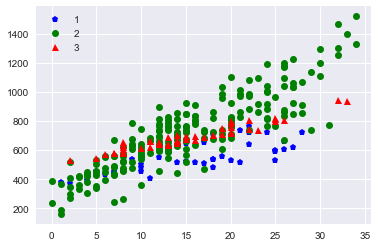

In [44]:
syms = ['bp', 'go', 'r^', 'cs', 'mD', 'yv']
df_ex4 = pd.read_csv('../chap08/input/data-salary-3.txt')
for i in range(1,4):
    df = df_ex4[df_ex4['GID']==i]
    plt.plot(df['X'], df['Y'], syms[i-1], label=str(i))
plt.legend(loc='best')
plt.show()

In [45]:
data_ex4 = df_ex4.to_dict('list')
data_ex4['N'] = len(df_ex4)
data_ex4['G'] = np.max(df_ex4['GID'])
data_ex4['K'] = np.max(df_ex4['KID'])
d = dict()
for kid,gid in zip(df_ex4['KID'], df_ex4['GID']):
    d[kid] = gid
data_ex4['K2G'] = [d[k] for k in sorted(list(d.keys()))] 

In [46]:
fit_ex4 = pystan.stan(model_code=model_9_ex4, data=data_ex4, iter=1000, chains=4)
print(fit_ex4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7bae6e7e4395ba5f339be9d9216c22c8 NOW.


Inference for Stan model: anon_model_7bae6e7e4395ba5f339be9d9216c22c8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0     -7151  5741.2  2.1e4 -6.6e4 -1.5e4  -4436 4236.2  1.6e4     14   1.33
b0    2652.9  2457.5  1.2e4 -2.1e4  -3855 2113.3 8539.4  2.5e4     22   1.19
a1[0] -289.0  3273.3 9258.3 -1.8e4  -7002 1706.4 5913.2  1.6e4      8   1.71
a1[1]  -6182  4682.2 8109.8 -2.0e4 -1.2e4  -7519 1185.7 7651.3      3   2.57
a1[2]  -2004  3609.2 8070.5 -1.7e4  -6962 -954.9 4255.2  1.3e4      5   1.76
b1[0] 844.98  3274.5 9261.8 -1.5e4  -5332  -1160 7574.5  1.8e4      8   1.71
b1[1] 6911.9  4683.0 8111.2  -6945 -507.6 8238.8  1.3e4  2.1e4      3   2.57
b1[2] 2680.3  3609.7 8071.5 -1.2e4  -3591 1685.9 7643.8  1.8e4      5   1.76
a[0]  -316.6  3275.3 9264.0 -1.8e4  -7044 1697.0 5874.8  1.6e4      8   1.71
a[1]  -289.2  3273.5 9258.9 -1.8e4  -7027 1

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


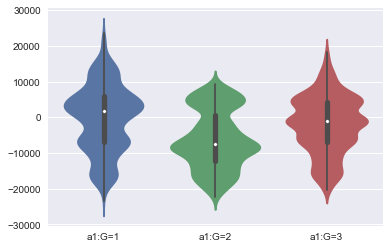

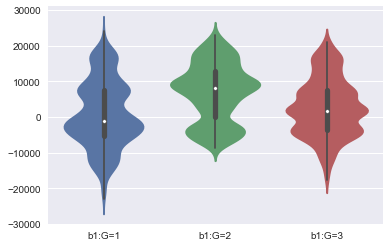

In [47]:
df = pd.DataFrame(fit_ex4.extract(permuted=True)['a1'])
df.columns = ['a1:G=1', 'a1:G=2', 'a1:G=3']
sns.violinplot(df)
plt.show()
df = pd.DataFrame(fit_ex4.extract(permuted=True)['b1'])
df.columns = ['b1:G=1', 'b1:G=2', 'b1:G=3']
sns.violinplot(df)
plt.show()

## 練習問題(5)

### min
* `int min(int x, int y)`
* `int min(int x[])`
* `real min(real x[])`
* `real min(vector x)`
* `real min(row_vector x)`
* `real min(matrix x)`

### fmin
* `real fmin(real x, real y)`